<a href="https://colab.research.google.com/github/Uzi78/ML_Projects/blob/main/Manga_Anime_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Import and Initial Exploration

### Import Libraries:
The code begins by importing essential libraries for data manipulation (pandas, numpy), visualization (matplotlib.pyplot, seaborn), and suppressing warnings.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load Data:
Two CSV files, anime.csv and rating.csv, are loaded into Pandas DataFrames named anime and rating.

In [2]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')


### Initial Data Inspection:
The first few rows of both DataFrames are printed to provide an overview of the dataset's structure and contents.


In [5]:
print("The Anime information: ")
print(anime.head())
print("The Rating information: ")
print(rating.head())

The Anime information: 
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  
The Rating information: 
   user_id  anime_id  rating
0        1        20    -1.0
1        1        24    -1.0
2        1


### Missing Values Check:
The code checks for missing values in both DataFrames, which is crucial for ensuring data quality before analysis.

In [6]:
print(anime.isnull().sum())
print(rating.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
user_id     0
anime_id    0
rating      1
dtype: int64


## Data Cleaning

### Fill Missing Values:
Missing values in the genre and type columns of the anime DataFrame are filled with "Unknown". The rating column is converted to numeric, coercing errors to NaN, and then filled with the mean rating.


In [16]:
anime["genre"].fillna("Unknown", inplace=True)
anime["type"].fillna("Unknown", inplace=True)
anime["rating"] = pd.to_numeric(anime["rating"], errors='coerce')
anime["rating"].fillna(anime["rating"].mean(), inplace=True)


### Genre Processing:
The genre column is transformed from a string representation into a list of genres for each anime.

In [10]:
anime["genre"] = anime["genre"].apply(lambda x: x.split(", ") if isinstance(x, str) else [])

In [11]:
merge= rating.merge(anime, on="anime_id")
print(merge.head())

   user_id  anime_id  rating_x                       name  \
0        1        20      -1.0                     Naruto   
1        1        24      -1.0              School Rumble   
2        1        79      -1.0                   Shuffle!   
3        1       226      -1.0                 Elfen Lied   
4        1       241      -1.0  Girls Bravo: First Season   

                                               genre type episodes rating_y  \
0  [Action, Comedy, Martial Arts, Shounen, Super ...   TV      220     7.81   
1                 [Comedy, Romance, School, Shounen]   TV       26     8.06   
2  [Comedy, Drama, Ecchi, Fantasy, Harem, Magic, ...   TV       24     7.31   
3  [Action, Drama, Horror, Psychological, Romance...   TV       13     7.85   
4   [Comedy, Ecchi, Fantasy, Harem, Romance, School]   TV       11     6.69   

   members  
0   683297  
1   178553  
2   158772  
3   623511  
4    84395  


## Top Anime Visualization
### Top Rated Anime:
The top 10 highest-rated anime are identified by sorting the anime DataFrame based on the rating. This information is printed for review.


       anime_id                                     name  \
10464     33662  Taka no Tsume 8: Yoshida-kun no X-Files   
10400     30120              Spoon-hime no Swing Kitchen   
9595      23005                         Mogura no Motoro   
0         32281                           Kimi no Na wa.   
9078      33607                             Kahei no Umi   
1          5114         Fullmetal Alchemist: Brotherhood   
10786     26313          Yakusoku: Africa Mizu to Midori   
2         28977                                 Gintama°   
3          9253                              Steins;Gate   
4          9969                            Gintama&#039;   

                                                   genre   type episodes  \
10464                                   [Comedy, Parody]  Movie        1   
10400                                  [Adventure, Kids]     TV  Unknown   
9595                                     [Slice of Life]  Movie        1   
0                 [Drama, Romance, 

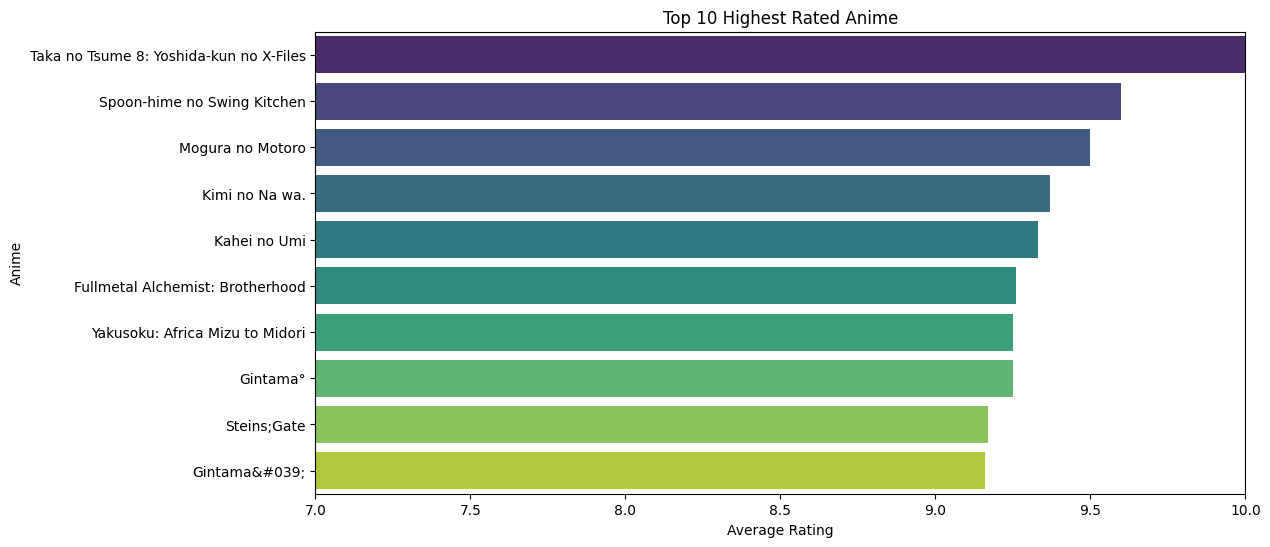

In [22]:
top_anime = anime.sort_values(by="rating", ascending=False).head(10)
print(top_anime)

plt.figure(figsize=(12, 6))
sns.barplot(x="rating", y="name", data=top_anime, palette="viridis")
plt.xlabel("Average Rating")
plt.ylabel("Anime")
plt.title("Top 10 Highest Rated Anime")
plt.xlim(7, 10)
plt.show()

### Bar Plot Visualization:
A bar plot is created using Seaborn to visually represent the average ratings of the top 10 highest-rated anime, providing a clear comparison among them.

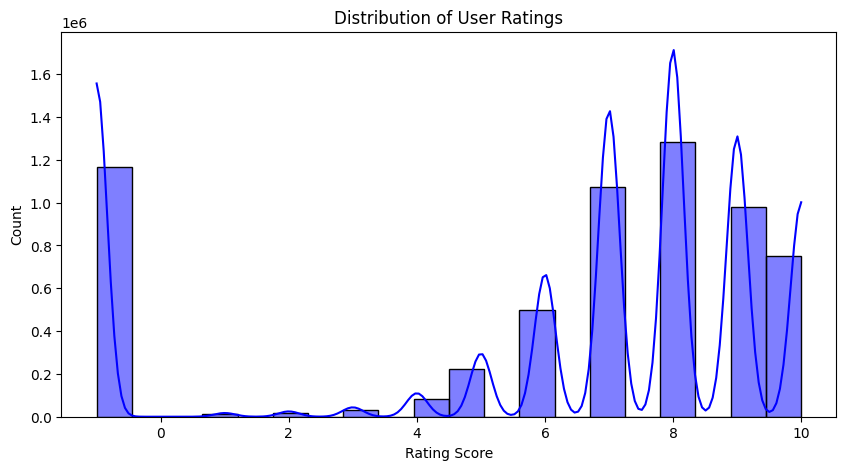

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(rating["rating"], bins=20, kde=True, color="blue")
plt.xlabel("Rating Score")
plt.ylabel("Count")
plt.title("Distribution of User Ratings")
plt.show()


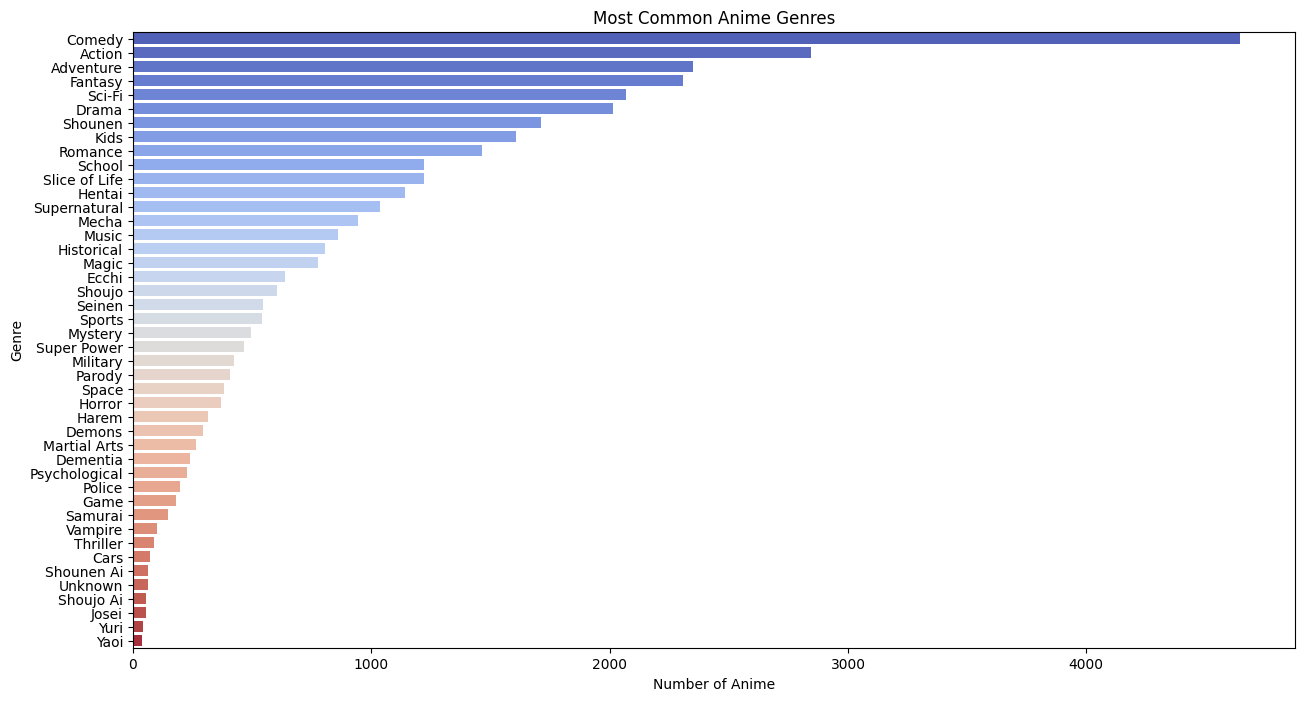

In [28]:
from collections import Counter

# Flatten genre lists and count occurrences
all_genres = [genre for sublist in anime["genre"] for genre in sublist]
genre_counts = Counter(all_genres)

# Convert to DataFrame
genre_df = pd.DataFrame(genre_counts.items(), columns=["Genre", "Count"])
genre_df = genre_df.sort_values(by="Count", ascending=False)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x="Count", y="Genre", data=genre_df, palette="coolwarm")
plt.xlabel("Number of Anime")
plt.ylabel("Genre")
plt.title("Most Common Anime Genres")
plt.show()


## Content-Based Filtering
Content-based filtering recommends anime based on their features, such as genres, type, and average rating. The idea is:

"If a user likes an anime with certain characteristics, they will likely enjoy similar anime with the same characteristics."

For example, if a user watches and enjoys Attack on Titan (Action, Drama, Fantasy), the system might recommend Demon Slayer (Action, Fantasy, Shounen) because they share similar genres.

### TF-IDF Vectorization:
The genres are transformed into a string format suitable for analysis, and a TF-IDF vectorizer is used to create a matrix representing the importance of each genre across all anime.

### Cosine Similarity Calculation:
The cosine similarity between anime based on their genre features is calculated, which quantifies how similar different anime are to one another.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")

anime["genre_str"] = anime["genre"].apply(lambda x: " ".join(x))

tfidf_matrix = tfidf.fit_transform(anime["genre_str"])
print(tfidf_matrix.shape)

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim[:5, :5])

(12294, 47)
[[1.         0.14784981 0.         0.         0.        ]
 [0.14784981 1.         0.1786367  0.         0.1786367 ]
 [0.         0.1786367  1.         0.22094895 1.        ]
 [0.         0.         0.22094895 1.         0.22094895]
 [0.         0.1786367  1.         0.22094895 1.        ]]


## Anime Recommendation Function

### Recommendation Function Definition:
 A function named recommend_anime is defined to provide recommendations based on a given anime title. It checks if the title exists in the dataset and retrieves similar anime based on cosine similarity scores.

In [44]:
def recommend_anime(title, anime_df, cosine_sim):

    if anime_df[anime_df["name"] == title].empty:
        print(f"Anime '{title}' not found in the database.")
        return None

    idx = anime_df[anime_df["name"] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    anime_indices = [i[0] for i in sim_scores]
    return anime_df.iloc[anime_indices][["name", "genre"]]

In [46]:
recommendations = recommend_anime("Kimi no Na wa.", anime, cosine_sim)
print(recommendations)

                                       name  \
5805            Wind: A Breath of Heart OVA   
6394           Wind: A Breath of Heart (TV)   
1111  Aura: Maryuuin Kouga Saigo no Tatakai   
1201         Angel Beats!: Another Epilogue   
1494                               Harmonie   
878           Shakugan no Shana II (Second)   
986                       Shakugan no Shana   
1604                    Shakugan no Shana S   
1959                              Air Movie   
4514                           Touka Gettan   

                                                  genre  
5805             [Drama, Romance, School, Supernatural]  
6394             [Drama, Romance, School, Supernatural]  
1111     [Comedy, Drama, Romance, School, Supernatural]  
1201                      [Drama, School, Supernatural]  
1494                      [Drama, School, Supernatural]  
878   [Action, Drama, Fantasy, Romance, School, Supe...  
986   [Action, Drama, Fantasy, Romance, School, Supe...  
1604  [Action, Dra